In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import preproc as pp

import numpy as np
import tensorflow as tf

version = "v2"
augp = Path("../scratch").joinpath("train_augmented_" + version)
modelp = Path("../scratch").joinpath("models")

train_ir, test_ir = pp.load_data(val_size=0)
train_aug, test_aug = pp.load_aug_data(augp, train_ir.element_spec, test_ind=[5])

2023-02-24 17:29:18.413191: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-02-24 17:29:30.947761: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-24 17:29:31.287630: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:ca:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.41GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-24 17:29:31.287658: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-02-24 17:29:31.294197: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-02-24 17:29:31.294270: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas

In [2]:
a = tf.keras.applications.vgg16.VGG16()
a.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# 3.0 VGG Base

In [3]:
def conv_block(filters, kernel_size):
    return [
        tf.keras.layers.Conv2D(
            filters=filters
            , kernel_size=kernel_size
            , strides=1
            , padding="same"
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        ),
        tf.keras.layers.Conv2D(
            filters=filters
            , kernel_size=kernel_size
            , strides=1
            , padding="same"
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        ),
        tf.keras.layers.MaxPool2D(
            pool_size=2,
            strides=2,
            padding="valid"
        )
    ]

vggbase = tf.keras.Sequential([tf.keras.Input(shape=(28, 28, 1))]
    + conv_block(64, 3)
    + conv_block(128, 3)
    + [
        tf.keras.layers.Flatten()
        , tf.keras.layers.Dense(
            1024
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        )
        , tf.keras.layers.Dense(
            1024
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        )
        , tf.keras.layers.Dense(
            10
            , activation="softmax"
        )
    ]
)
vggbase.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

In [4]:
train_shape = tf.data.experimental.cardinality(train_aug).numpy()
val_size = 0.2

splitter = train_aug.shuffle(10000, reshuffle_each_iteration=False)
val_ds = splitter.take(train_shape * val_size).batch(512)
train_ds = splitter.skip(train_shape * val_size).batch(512)

Epoch 1/100
844/844 [==============================] - 22s 24ms/step - loss: 0.5830 - accuracy: 0.8104 - val_loss: 0.0405 - val_accuracy: 0.9878
Epoch 2/100
844/844 [==============================] - 21s 22ms/step - loss: 0.0368 - accuracy: 0.9890 - val_loss: 0.0316 - val_accuracy: 0.9912
Epoch 3/100
844/844 [==============================] - 21s 23ms/step - loss: 0.0219 - accuracy: 0.9937 - val_loss: 0.0313 - val_accuracy: 0.9920
Epoch 4/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0160 - accuracy: 0.9954 - val_loss: 0.0373 - val_accuracy: 0.9919
Epoch 5/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0146 - accuracy: 0.9959 - val_loss: 0.0335 - val_accuracy: 0.9924
Epoch 6/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0134 - accuracy: 0.9964 - val_loss: 0.0456 - val_accuracy: 0.9919


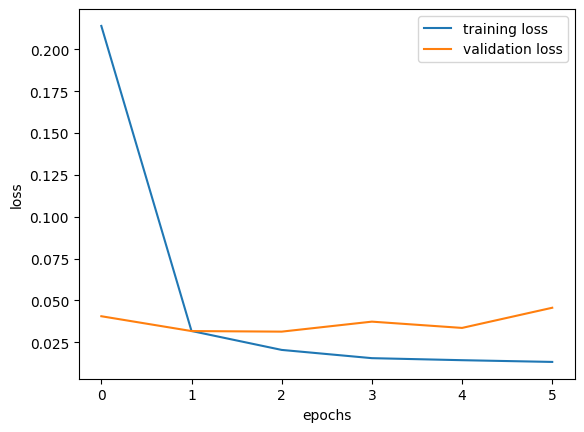

In [6]:
import datetime

vggbase.compile(
    loss='categorical_crossentropy'
    , optimizer="rmsprop"
    , metrics=["accuracy"]
)

history = vggbase.fit(
    train_ds
    , validation_data=val_ds
    , epochs=100
    , callbacks=[
        tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=5)
    ]
)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [10]:
_ = vggbase.fit(x_train, y_train, epochs=1, batch_size=512)

118/118 [==============================] - 1s 11ms/step - loss: 0.0198 - accuracy: 0.9956


In [11]:
(x_train, y_train), (x_test, y_test) = pp.load_data(return_eval=True)

vggbase.evaluate(x_train, y_train), vggbase.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0429 - accuracy: 0.9902


([0.030315332114696503, 0.9943666458129883],
 [0.042939815670251846, 0.9901999831199646])

In [12]:
pp.plot_confusion_matrix(x_test, y_test, vggbase)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 976,    0,    0,    0,    0,    0,    2,    1,    1,    0],
       [   0, 1131,    0,    1,    0,    0,    0,    2,    0,    1],
       [   0,    1, 1025,    0,    0,    0,    0,    6,    0,    0],
       [   0,    1,    0, 1008,    0,    0,    0,    0,    1,    0],
       [   0,    0,    0,    0,  974,    0,    0,    0,    0,    8],
       [   0,    1,    1,   21,    0,  864,    1,    1,    3,    0],
       [   1,    5,    0,    0,    2,    0,  947,    0,    3,    0],
       [   0,    3,    0,    2,    0,    0,    0, 1018,    1,    4],
       [   0,    0,    2,    5,    0,    1,    0,    0,  966,    0],
       [   0,    0,    0,    7,    9,    0,    0,    0,    0,  993]],
      dtype=int32)>

In [13]:
vggbase.evaluate(train_ds), vggbase.evaluate(val_ds), vggbase.evaluate(test_aug.batch(512))

118/118 [==============================] - 1s 12ms/step - loss: 0.3835 - accuracy: 0.9579


([0.37606409192085266, 0.961597204208374],
 [0.3832643926143646, 0.959324061870575],
 [0.3834851384162903, 0.9579333066940308])

In [14]:
vggbase.save(modelp.joinpath("vggbase." + version + ".h5").resolve().as_posix(), save_format="h5")

# 3.1 VGG Dropout

In [15]:
def conv_block(filters, kernel_size):
    return [
        tf.keras.layers.Conv2D(
            filters=filters
            , kernel_size=kernel_size
            , strides=1
            , padding="same"
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        ),
        tf.keras.layers.Conv2D(
            filters=filters
            , kernel_size=kernel_size
            , strides=1
            , padding="same"
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        ),
        tf.keras.layers.MaxPool2D(
            pool_size=2,
            strides=2,
            padding="valid"
        )
    ]

vggreg = tf.keras.Sequential([tf.keras.Input(shape=(28, 28, 1))]
    + conv_block(64, 3)
    + conv_block(128, 3)
    + [
        tf.keras.layers.Flatten()
        , tf.keras.layers.Dense(
            1024
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        )
        , tf.keras.layers.Dropout(0.5)
        , tf.keras.layers.Dense(
            1024
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        )
        , tf.keras.layers.Dense(
            10
            , activation="softmax"
        )
    ]
)
net = vggreg
net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [16]:
train_shape = tf.data.experimental.cardinality(train_aug).numpy()
val_size = 0.2

splitter = train_aug.shuffle(10000, reshuffle_each_iteration=False)
val_ds = splitter.take(train_shape * val_size).batch(512)
train_ds = splitter.skip(train_shape * val_size).batch(512)

Epoch 1/100
844/844 [==============================] - 21s 22ms/step - loss: 0.5732 - accuracy: 0.8097 - val_loss: 0.0482 - val_accuracy: 0.9859
Epoch 2/100
844/844 [==============================] - 21s 22ms/step - loss: 0.0470 - accuracy: 0.9863 - val_loss: 0.0352 - val_accuracy: 0.9893
Epoch 3/100
844/844 [==============================] - 21s 22ms/step - loss: 0.0333 - accuracy: 0.9902 - val_loss: 0.0262 - val_accuracy: 0.9922
Epoch 4/100
844/844 [==============================] - 21s 22ms/step - loss: 0.0285 - accuracy: 0.9918 - val_loss: 0.0274 - val_accuracy: 0.9925
Epoch 5/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0261 - accuracy: 0.9927 - val_loss: 0.0224 - val_accuracy: 0.9933
Epoch 6/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0266 - accuracy: 0.9928 - val_loss: 0.0245 - val_accuracy: 0.9926
Epoch 7/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0253 - accuracy: 0.9930 - val_loss: 0.0264 - val_ac

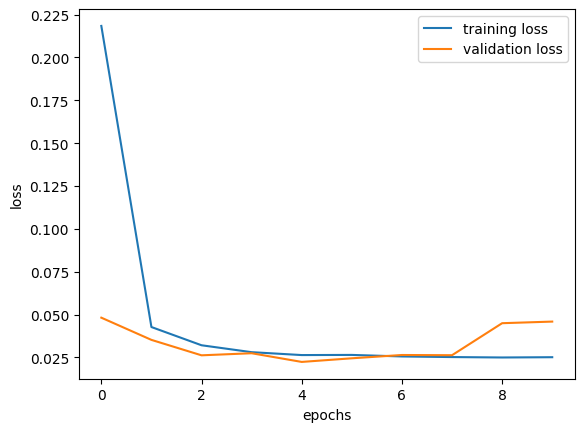

In [17]:
import datetime

net.compile(
    loss='categorical_crossentropy'
    , optimizer="rmsprop"
    , metrics=["accuracy"]
)

history = net.fit(
    train_ds
    , validation_data=val_ds
    , epochs=100
    , callbacks=[
        tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=5)
    ]
)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [21]:
_ = net.fit(x_train, y_train, epochs=1, batch_size=512)

118/118 [==============================] - 1s 11ms/step - loss: 0.0280 - accuracy: 0.9936


In [22]:
(x_train, y_train), (x_test, y_test) = pp.load_data(return_eval=True)

net.evaluate(x_train, y_train), net.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0691 - accuracy: 0.9902


([0.03156949207186699, 0.994350016117096],
 [0.06912887841463089, 0.9901999831199646])

In [23]:
pp.plot_confusion_matrix(x_test, y_test, net)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 979,    0,    0,    0,    0,    1,    0,    0,    0,    0],
       [   0, 1131,    2,    1,    0,    0,    1,    0,    0,    0],
       [   1,    0, 1028,    3,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 1010,    0,    0,    0,    0,    0,    0],
       [   0,    0,    1,    0,  975,    0,    1,    1,    0,    4],
       [   0,    0,    0,   13,    0,  876,    2,    1,    0,    0],
       [   6,    2,    0,    0,    1,    0,  949,    0,    0,    0],
       [   0,    4,   22,    8,    0,    0,    0,  990,    0,    4],
       [   0,    0,    1,    7,    1,    1,    0,    0,  964,    0],
       [   0,    0,    0,    2,    7,    0,    0,    0,    0, 1000]],
      dtype=int32)>

In [24]:
net.evaluate(train_ds), net.evaluate(val_ds), net.evaluate(test_aug.batch(512))

118/118 [==============================] - 1s 12ms/step - loss: 0.0773 - accuracy: 0.9831


([0.06191731244325638, 0.9849722385406494],
 [0.07827036082744598, 0.9830740690231323],
 [0.07733505964279175, 0.9831166863441467])

In [25]:
net.save(modelp.joinpath("vgg_3.1."+version+".h5").resolve().as_posix(), save_format="h5")

## 3.2 VGG 3.1 Mod1

In [26]:
def conv_block(filters, kernel_size):
    return [
        tf.keras.layers.Conv2D(
            filters=filters
            , kernel_size=kernel_size
            , strides=1
            , padding="same"
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        ),
        tf.keras.layers.Conv2D(
            filters=filters
            , kernel_size=kernel_size
            , strides=1
            , padding="same"
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        ),
        tf.keras.layers.MaxPool2D(
            pool_size=2,
            strides=2,
            padding="valid"
        )
    ]

vggbase = tf.keras.Sequential([tf.keras.Input(shape=(28, 28, 1))]
    + conv_block(64, 3)
    + conv_block(128, 3)
    + [
        tf.keras.layers.Flatten()
        , tf.keras.layers.Dense(
            1024
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        )
        , tf.keras.layers.Dropout(0.5)
        , tf.keras.layers.Dense(
            512
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        )
        , tf.keras.layers.Dropout(0.5)
        , tf.keras.layers.Dense(
            10
            , activation="softmax"
        )
    ]
)
net = vggbase
net.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)             

In [27]:
train_shape = tf.data.experimental.cardinality(train_aug).numpy()
val_size = 0.2

splitter = train_aug.shuffle(10000, reshuffle_each_iteration=False)
val_ds = splitter.take(train_shape * val_size).batch(512)
train_ds = splitter.skip(train_shape * val_size).batch(512)

Epoch 1/100
844/844 [==============================] - 21s 22ms/step - loss: 0.5632 - accuracy: 0.8134 - val_loss: 0.0582 - val_accuracy: 0.9825
Epoch 2/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0507 - accuracy: 0.9851 - val_loss: 0.0358 - val_accuracy: 0.9898
Epoch 3/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0366 - accuracy: 0.9898 - val_loss: 0.0338 - val_accuracy: 0.9906
Epoch 4/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0328 - accuracy: 0.9910 - val_loss: 0.0393 - val_accuracy: 0.9895
Epoch 5/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0326 - accuracy: 0.9912 - val_loss: 0.0302 - val_accuracy: 0.9924
Epoch 6/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0324 - accuracy: 0.9915 - val_loss: 0.0482 - val_accuracy: 0.9909
Epoch 7/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0327 - accuracy: 0.9917 - val_loss: 0.0334 - val_ac

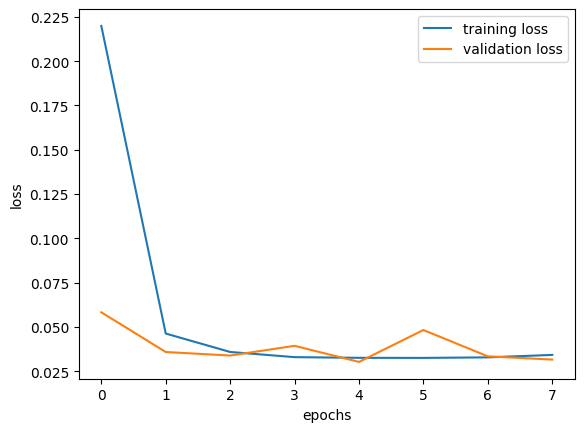

In [28]:
import datetime

net.compile(
    loss='categorical_crossentropy'
    , optimizer="rmsprop"
    , metrics=["accuracy"]
)

history = net.fit(
    train_ds
    , validation_data=val_ds
    , epochs=100
    , callbacks=[
        tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=3)
    ]
)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [32]:
_ = net.fit(x_train, y_train, epochs=1, batch_size=512)

118/118 [==============================] - 1s 11ms/step - loss: 0.0351 - accuracy: 0.9919


In [33]:
(x_train, y_train), (x_test, y_test) = pp.load_data(return_eval=True)

net.evaluate(x_train, y_train), net.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0266 - accuracy: 0.9934


([0.01415741816163063, 0.9958166480064392],
 [0.02656857669353485, 0.993399977684021])

In [34]:
pp.plot_confusion_matrix(x_test, y_test, net)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 979,    0,    0,    0,    0,    0,    1,    0,    0,    0],
       [   4, 1120,    0,    1,    1,    0,    7,    0,    2,    0],
       [   0,    0, 1031,    0,    0,    0,    0,    1,    0,    0],
       [   0,    0,    3, 1004,    0,    2,    0,    0,    1,    0],
       [   0,    0,    0,    0,  976,    0,    0,    0,    2,    4],
       [   0,    0,    0,    1,    0,  888,    2,    1,    0,    0],
       [   3,    0,    0,    0,    1,    1,  952,    0,    1,    0],
       [   0,    2,    8,    0,    0,    0,    0, 1017,    0,    1],
       [   1,    0,    3,    0,    0,    1,    0,    0,  969,    0],
       [   0,    0,    0,    1,    4,    1,    0,    1,    4,  998]],
      dtype=int32)>

In [35]:
net.evaluate(train_ds), net.evaluate(val_ds), net.evaluate(test_aug.batch(512))

118/118 [==============================] - 2s 13ms/step - loss: 0.0752 - accuracy: 0.9793


([0.06492283195257187, 0.9818541407585144],
 [0.07586977630853653, 0.9792037010192871],
 [0.07519837468862534, 0.9793499708175659])

In [77]:
net.save(modelp.joinpath("vgg_3.1mod1."+version+".h5").resolve().as_posix(), save_format="h5")

## 3.3 VGG 3.1 Mod2

In [64]:
def conv_block(filters, kernel_size):
    return [
        tf.keras.layers.Conv2D(
            filters=filters
            , kernel_size=kernel_size
            , strides=1
            , padding="same"
            , activation="relu"
            , use_bias=True
            , kernel_initializer="he_uniform"
            , bias_initializer="zeros"
        ),
        tf.keras.layers.Conv2D(
            filters=filters
            , kernel_size=kernel_size
            , strides=1
            , padding="same"
            , activation="relu"
            , use_bias=True
            , kernel_initializer="he_uniform"
            , bias_initializer="zeros"
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(
            pool_size=2,
            strides=2,
            padding="valid"
        )
    ]

vggreg = tf.keras.Sequential([tf.keras.Input(shape=(28, 28, 1))]
    + conv_block(32, 3)
    + conv_block(64, 3)
    + [
        tf.keras.layers.Flatten()
        , tf.keras.layers.Dense(
            512
            , activation="relu"
            , use_bias=True
            , kernel_initializer="he_uniform"
            , bias_initializer="zeros"
        )
        , tf.keras.layers.Dropout(0.3)
        , tf.keras.layers.Dense(
            512
            , activation="relu"
            , use_bias=True
            , kernel_initializer="he_uniform"
            , bias_initializer="zeros"
        )
        , tf.keras.layers.Dense(
            10
            , activation="softmax"
        )
    ]
)
net = vggreg
net.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 64)       

In [71]:
train_shape = tf.data.experimental.cardinality(train_aug).numpy()
val_size = 0.2

splitter = train_aug.shuffle(10000, reshuffle_each_iteration=False)
val_ds = splitter.take(train_shape * val_size).batch(512)
train_ds = splitter.skip(train_shape * val_size).batch(512)

2023-02-24 20:56:18.815471: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-02-24 20:56:18.815493: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-02-24 20:56:19.438280: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-02-24 20:56:19.438381: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


  2/938 [..............................] - ETA: 5:47 - loss: 0.0081 - accuracy: 0.9985 

2023-02-24 20:56:21.995129: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-02-24 20:56:21.995153: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 11/938 [..............................] - ETA: 4:28 - loss: 0.0065 - accuracy: 0.9985

2023-02-24 20:56:24.489702: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-02-24 20:56:24.490218: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-02-24 20:56:24.539740: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 201 callback api events and 189 activity events. 
2023-02-24 20:56:24.552928: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-02-24 20:56:24.590713: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: vgg3.1mod2_logs/train/plugins/profile/2023_02_24_20_56_24
2023-02-24 20:56:24.614425: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to vgg3.1mod2_logs/train/plugins/profile/2023_02_24_20_56_24/erc-hpc-comp036.trace.json.gz
2023-02-24 20:56:24.633184: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating di

938/938 [==============================] - 23s 22ms/step - loss: 0.0064 - accuracy: 0.9980 - val_loss: 0.0174 - val_accuracy: 0.9952


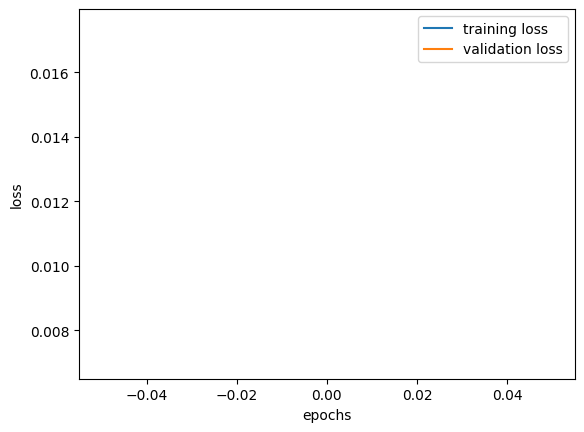

In [91]:
import datetime

net.compile(
    loss='categorical_crossentropy'
    , optimizer=tf.keras.optimizers.SGD(nesterov=True, momentum=0.9)
    , metrics=["accuracy"]
)

history = net.fit(
    train_ds
    , validation_data=val_ds
    , epochs=1
    , callbacks=[
        # tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=5)
        # , tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-5)
        tf.keras.callbacks.TensorBoard(log_dir="vgg3.1mod2_logs", histogram_freq=1, write_graph=True, write_images=True)
    ]
)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [50]:
# epochs=1
_ = net.fit(x_train, y_train, epochs=1, batch_size=512)

118/118 [==============================] - 1s 7ms/step - loss: 0.0170 - accuracy: 0.9946


In [51]:
augp = Path("../scratch").joinpath("train_augmented_v1")
# epochs=1
train_aug, _ = pp.load_aug_data(augp.resolve(), train_ir.element_spec, test_ind=[])
_ = net.fit(train_aug.batch(512), epochs=1)

1172/1172 [==============================] - 18s 15ms/step - loss: 0.0126 - accuracy: 0.9960


In [92]:
(x_train, y_train), (x_test, y_test) = pp.load_data(return_eval=True)

net.evaluate(x_train, y_train), net.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0313 - accuracy: 0.9921


([0.017857475206255913, 0.9948999881744385],
 [0.03132673725485802, 0.9921000003814697])

In [93]:
pp.plot_confusion_matrix(x_test, y_test, net)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 979,    0,    0,    0,    0,    1,    0,    0,    0,    0],
       [   0, 1128,    1,    0,    0,    0,    0,    2,    4,    0],
       [   1,    0, 1025,    1,    0,    0,    0,    4,    1,    0],
       [   0,    0,    0, 1010,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,  969,    0,    0,    3,    2,    8],
       [   0,    0,    0,    0,    0,  885,    5,    1,    1,    0],
       [   4,    3,    0,    0,    1,    0,  946,    0,    4,    0],
       [   0,    2,    6,    1,    2,    0,    0, 1016,    1,    0],
       [   0,    0,    1,    0,    1,    2,    0,    2,  968,    0],
       [   0,    0,    0,    0,    5,    2,    0,    4,    3,  995]],
      dtype=int32)>

In [94]:
test_aug_lab = np.array(list(test_aug.map(lambda _, y: y).as_numpy_iterator()))
test_aug_preds = np.array(list(net.predict(test_aug.batch(512))))
tf.math.confusion_matrix(np.argmax(test_aug_lab, axis=1), np.argmax(test_aug_preds, axis=1))

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[5448,   10,   63,   16,   16,   31,  104,   57,   77,  101],
       [  10, 6152,  209,    2,   20,   87,   21,  224,   10,    7],
       [  62,   26, 4785,   38,  165,   31,   49,  343,  382,   77],
       [  76,   14,  179, 5013,  167,  128,   85,  240,  183,   46],
       [  14,   98,  144,   30, 4795,  170,   28,  147,  338,   78],
       [  72,   27,   40,   43,  175, 4438,  211,   92,  110,  213],
       [ 103,   49,   92,   21,   78,  252, 4888,    4,  286,  145],
       [  42,  238,  516,   69,  108,   90,    1, 5086,   44,   71],
       [  80,   14,  142,    8,  111,   31,  114,   22, 5153,  176],
       [  98,   26,  107,   15,  116,  225,   76,   75,  329, 4882]],
      dtype=int32)>

In [95]:
net.evaluate(train_ds), net.evaluate(val_ds), net.evaluate(test_aug.batch(512))

118/118 [==============================] - 1s 11ms/step - loss: 1.1248 - accuracy: 0.8440


([0.002886486006900668, 0.9991416931152344],
 [0.017444388940930367, 0.9952083230018616],
 [1.1247575283050537, 0.843999981880188])

In [49]:
net.save(modelp.joinpath("vgg_3.1mod2."+version+".h5").resolve().as_posix(), save_format="h5")

# 3.4 VGG Alt

In [77]:
inputs = tf.keras.layers.Input(shape=(28, 28, 1))

# block 1
filters = 16
c1 = tf.keras.layers.Conv2D(
    filters=filters
    , kernel_size=3
    , strides=1
    , padding="same"
    , activation="relu"
    , use_bias=True
    , kernel_initializer="he_uniform"
    , bias_initializer="zeros"
)(inputs)
c2 = tf.keras.layers.Conv2D(
    filters=filters
    , kernel_size=3
    , strides=1
    , padding="same"
    , activation="relu"
    , use_bias=True
    , kernel_initializer="he_uniform"
    , bias_initializer="zeros"
)(c1)
bn = tf.keras.layers.BatchNormalization()(c2)
sc = tf.keras.layers.Conv2D(
    filters=filters
    , kernel_size=2
    , strides=2
    , padding="same"
    , activation="relu"
    , use_bias=True
    , kernel_initializer="he_uniform"
    , bias_initializer="zeros"
)(bn)


# block 2
filters = 32
c1 = tf.keras.layers.Conv2D(
    filters=filters
    , kernel_size=3
    , strides=1
    , padding="same"
    , activation="relu"
    , use_bias=True
    , kernel_initializer="he_uniform"
    , bias_initializer="zeros"
)(sc)
c2 = tf.keras.layers.Conv2D(
    filters=filters
    , kernel_size=3
    , strides=1
    , padding="same"
    , activation="relu"
    , use_bias=True
    , kernel_initializer="he_uniform"
    , bias_initializer="zeros"
)(c1)
bn = tf.keras.layers.BatchNormalization()(c2)
sc = tf.keras.layers.Conv2D(
    filters=filters
    , kernel_size=2
    , strides=2
    , padding="same"
    , activation="relu"
    , use_bias=True
    , kernel_initializer="he_uniform"
    , bias_initializer="zeros"
)(bn)


# block 3
filters = 64
c1 = tf.keras.layers.Conv2D(
    filters=filters
    , kernel_size=3
    , strides=1
    , padding="same"
    , activation="relu"
    , use_bias=True
    , kernel_initializer="he_uniform"
    , bias_initializer="zeros"
)(sc)
c2 = tf.keras.layers.Conv2D(
    filters=filters
    , kernel_size=3
    , strides=1
    , padding="same"
    , activation="relu"
    , use_bias=True
    , kernel_initializer="he_uniform"
    , bias_initializer="zeros"
)(c1)
bn = tf.keras.layers.BatchNormalization()(c2)

fl = tf.keras.layers.Flatten()(bn)
d1 = tf.keras.layers.Dense(
    512
    , activation="relu"
    , use_bias=True
    , kernel_initializer="he_uniform"
    , bias_initializer="zeros"
)(fl)
dp1 = tf.keras.layers.Dropout(0.3)(d1)
d2 = tf.keras.layers.Dense(
    512
    , activation="relu"
    , use_bias=True
    , kernel_initializer="he_uniform"
    , bias_initializer="zeros"
)(dp1)
dp2 = tf.keras.layers.Dropout(0.3)(d2)
outputs = tf.keras.layers.Dense(10, activation="softmax")(dp2)

net = tf.keras.Model(inputs=inputs, outputs=outputs)
net.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 28, 28, 16)        2320      
_________________________________________________________________
batch_normalization_14 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 14, 14, 16)        1040      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 14, 32)        9248

In [78]:
train_shape = tf.data.experimental.cardinality(train_aug).numpy()
val_size = 0.2

splitter = train_aug.shuffle(10000, reshuffle_each_iteration=False)
val_ds = splitter.take(train_shape * val_size).batch(512)
train_ds = splitter.skip(train_shape * val_size).batch(512)

2023-02-24 20:48:45.354613: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-02-24 20:48:45.354639: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-02-24 20:48:47.331903: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-02-24 20:48:47.332030: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


Epoch 1/6
  2/938 [..............................] - ETA: 6:28 - loss: 0.0152 - accuracy: 0.9946 

2023-02-24 20:48:50.100716: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-02-24 20:48:50.100741: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 14/938 [..............................] - ETA: 2:21 - loss: 0.0162 - accuracy: 0.9942

2023-02-24 20:48:51.531139: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-02-24 20:48:51.531972: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-02-24 20:48:51.620388: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 268 callback api events and 256 activity events. 
2023-02-24 20:48:51.639145: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-02-24 20:48:51.686841: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: vggalt_logs/train/plugins/profile/2023_02_24_20_48_51
2023-02-24 20:48:51.712009: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to vggalt_logs/train/plugins/profile/2023_02_24_20_48_51/erc-hpc-comp036.trace.json.gz
2023-02-24 20:48:51.742168: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory:

938/938 [==============================] - 22s 21ms/step - loss: 0.0169 - accuracy: 0.9944 - val_loss: 0.0291 - val_accuracy: 0.9914
Epoch 2/6
938/938 [==============================] - 20s 19ms/step - loss: 0.0153 - accuracy: 0.9952 - val_loss: 0.0319 - val_accuracy: 0.9898
Epoch 3/6
938/938 [==============================] - 19s 19ms/step - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.0266 - val_accuracy: 0.9919
Epoch 4/6
938/938 [==============================] - 20s 19ms/step - loss: 0.0125 - accuracy: 0.9959 - val_loss: 0.0317 - val_accuracy: 0.9904
Epoch 5/6
938/938 [==============================] - 21s 20ms/step - loss: 0.0118 - accuracy: 0.9961 - val_loss: 0.0274 - val_accuracy: 0.9919
Epoch 6/6
938/938 [==============================] - 20s 19ms/step - loss: 0.0107 - accuracy: 0.9965 - val_loss: 0.0415 - val_accuracy: 0.9887


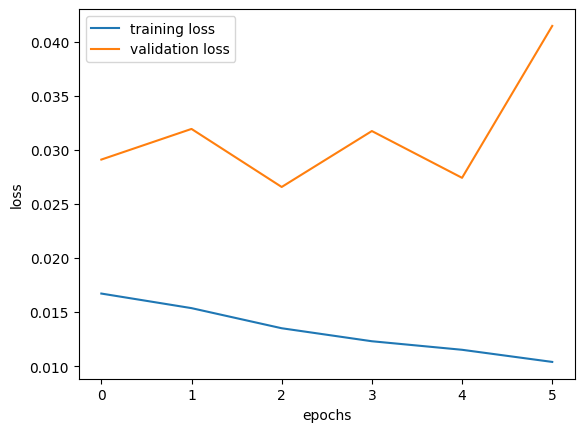

In [81]:
import datetime

net.compile(
    loss='categorical_crossentropy'
    , optimizer=tf.keras.optimizers.SGD(nesterov=True, momentum=0.9)
    , metrics=["accuracy"]
)

history = net.fit(
    train_ds
    , validation_data=val_ds
    , epochs=6
    , callbacks=[
        tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=5)
        , tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-5)
        , tf.keras.callbacks.TensorBoard(log_dir="vggalt_logs", histogram_freq=1, write_graph=True, write_images=True)
    ]
)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [15]:
# epochs=1
_ = net.fit(x_train, y_train, epochs=1, batch_size=512)

118/118 [==============================] - 1s 7ms/step - loss: 0.0408 - accuracy: 0.9893


In [27]:
augp = Path("../scratch").joinpath("train_augmented_v1")
# epochs=1
train_aug, _ = pp.load_aug_data(augp.resolve(), train_ir.element_spec, test_ind=[])
_ = net.fit(train_aug.batch(512), epochs=1)

1172/1172 [==============================] - 18s 16ms/step - loss: 0.0078 - accuracy: 0.9977


In [84]:
(x_train, y_train), (x_test, y_test) = pp.load_data(return_eval=True)

net.evaluate(x_train, y_train), net.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0629 - accuracy: 0.9851


([0.05423865094780922, 0.9871833324432373],
 [0.06290730088949203, 0.9850999712944031])

In [85]:
pp.plot_confusion_matrix(x_test, y_test, net)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 977,    0,    0,    0,    0,    1,    0,    0,    2,    0],
       [   0, 1089,    1,    1,    4,    0,    0,    6,   33,    1],
       [   1,    0, 1026,    0,    1,    0,    0,    3,    1,    0],
       [   0,    0,    1, 1007,    0,    1,    0,    0,    1,    0],
       [   0,    0,    1,    0,  974,    0,    0,    1,    1,    5],
       [   0,    0,    0,    7,    0,  880,    0,    1,    2,    2],
       [   4,    0,    4,    1,    5,   12,  910,    0,   22,    0],
       [   0,    0,    6,    0,    1,    0,    0, 1021,    0,    0],
       [   0,    1,    0,    0,    1,    0,    0,    2,  969,    1],
       [   0,    0,    0,    1,    6,    2,    0,    2,    0,  998]],
      dtype=int32)>

In [82]:
test_aug_lab = np.array(list(test_aug.map(lambda _, y: y).as_numpy_iterator()))
test_aug_preds = np.array(list(net.predict(test_aug.batch(512))))
tf.math.confusion_matrix(np.argmax(test_aug_lab, axis=1), np.argmax(test_aug_preds, axis=1))

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[5387,   20,  109,   41,   18,   18,   47,   47,  110,  126],
       [   8, 5976,   86,    2,   52,  116,   37,  333,  123,    9],
       [  38,   23, 4871,   77,  157,   24,   20,  386,  290,   72],
       [  33,   16,  125, 5086,  163,  113,   63,  320,  160,   52],
       [  17,   73,  212,   53, 4807,  151,   21,  233,  172,  103],
       [  64,   17,   27,   70,  156, 4494,  120,  107,  141,  225],
       [ 112,   25,   59,   62,   77,  369, 4622,    5,  440,  147],
       [  19,  178,  711,  164,  167,   80,    2, 4796,   33,  115],
       [  52,    9,  173,   22,  161,   54,   76,   16, 5119,  169],
       [ 133,   18,  192,   92,  108,  175,   41,   52,  303, 4835]],
      dtype=int32)>

In [83]:
net.evaluate(train_ds), net.evaluate(val_ds), net.evaluate(test_aug.batch(512))

118/118 [==============================] - 1s 11ms/step - loss: 0.9354 - accuracy: 0.8332


([0.021897492930293083, 0.9933916926383972],
 [0.041472166776657104, 0.9887166619300842],
 [0.9354327321052551, 0.833216667175293])

In [49]:
net.save(modelp.joinpath("vgg_3.1mod2."+version+".h5").resolve().as_posix(), save_format="h5")